# Проект: Прогнозирование оттока клиентов фитнес клуба

## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, silhouette_score
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.cluster.hierarchy import dendrogram, linkage

In [1]:
#df = pd.read_csv('###')

In [3]:
class DataFrameCheck:
    """
    Класс для выполнения базовых проверок датасета:
    1) Наличие дубликатов
    2) Проверка пропусков
    3) Общая информация
    4) Вывод статистики
    5) Вывод всей предыдущей информации
    """
    def dup_check(self, dataframe):
        print('Количество дубликатов в записях: {}'.format(dataframe.duplicated().sum()))
        
    def nan_check(self, dataframe):
        print("Пропуски(nan):")
        display(dataframe.isna().sum())
        
    def inf_check(self, dataframe):
        print("Общая информация:")
        display(dataframe.info())
        
    def desc_check(self, dataframe):
        display(dataframe.describe())
    
    def full_info(self, dataframe):
        self.inf_check(dataframe)
        self.dup_check(dataframe)
        self.nan_check(dataframe)
        self.desc_check(dataframe)

In [4]:
check = DataFrameCheck()

## Исследовательский анализ данных (EDA)

In [5]:
check.nan_check(df)

Пропуски(nan):


gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

<b>Вывод: Пропущенных значений в датасете нет</b>

<b>Сформируем список не бинарных столбцов:</b>

In [6]:
not_boolean_col = ['Contract_period', 'Age', 'Avg_additional_charges_total', 
                   'Month_to_end_contract', 'Lifetime', 
                   'Avg_class_frequency_total', 'Avg_class_frequency_current_month']

In [7]:
boolean_col = ['gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone',
       'Group_visits', 'Churn']

In [8]:
check.desc_check(df[not_boolean_col])

,Contract_period,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


In [9]:
check.desc_check(df[boolean_col])

,gender,Near_Location,Partner,Promo_friends,Phone,Group_visits,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,0.412250,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,0.492301,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b>Вывод</b>
* Больше всего контрактов на месяц, затем год и 6 месяцев
* Средний возраст состовляет +/- 29 лет
* Средняя суммарная выручка от других услуг фитнес центра составляет 136
* Больше всего сроков окончания абонемента - 1, что логично следует из первого пункта
* Время с момента первого обращение имеет среднее - 3
* Средняя частота посещения в неделю в среднем 1.8 - люди ходят 1-2 раза в неделю
* А за предыдущий месяц 1.7 - что имеет сходство с частотой за всё время абонемента
* В бинарных столбцах среднее по сотрудникам компании-партнёра в основном 0, также это и для акции "Приведи друга"
* Групповые занятие посещают не все и каждый - 0
* Целевой признак больше распределён по нормальным клиентам

###  Среднее значение признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [10]:
df_mean = df.groupby('Churn').agg('mean')

In [11]:
df_mean.T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


<b>Сравнение с ушедшими в отток:</b>
* Мальчиков и девочек одинаковое количество, телефонные номера присутствуют у всех
* Не попавшие в отток располагаются чуть ближе к залу и чаще участвуют в акции "Приведи друга"
* Сроки действия контрактов у попавших в отток короче, меньше групповых визитов 
* Суммарная выручка от доп. услуг клуба у попавших в отток меньше, как и время с момента первого обращения
* По частоте посещения за весь период те, кто попали в отток ходят реже остальных

### Столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

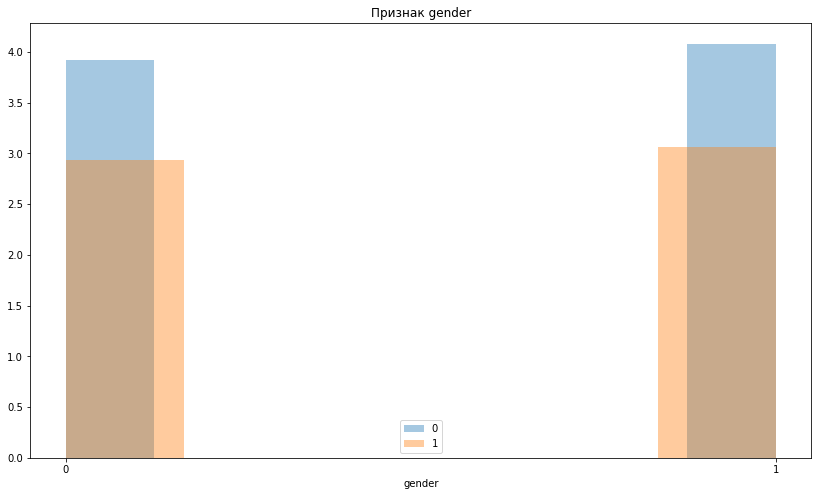

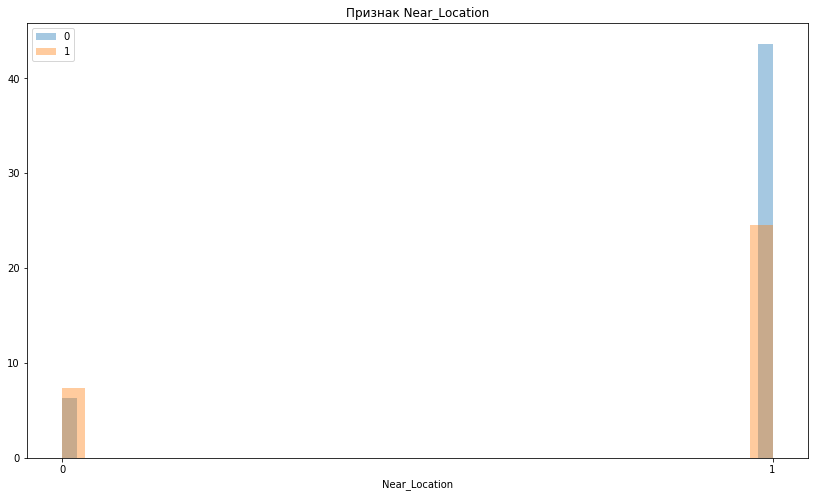

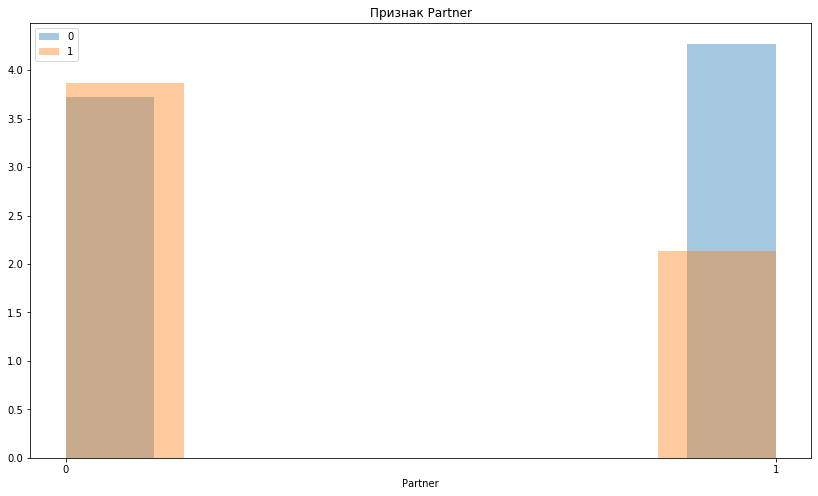

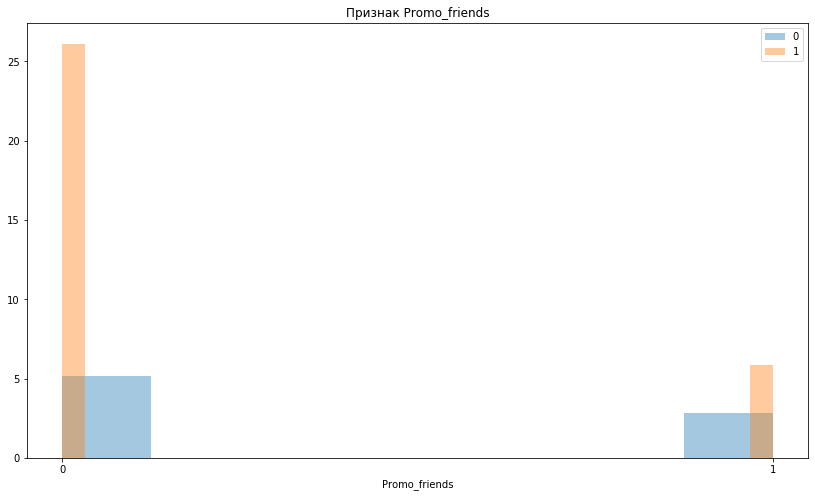

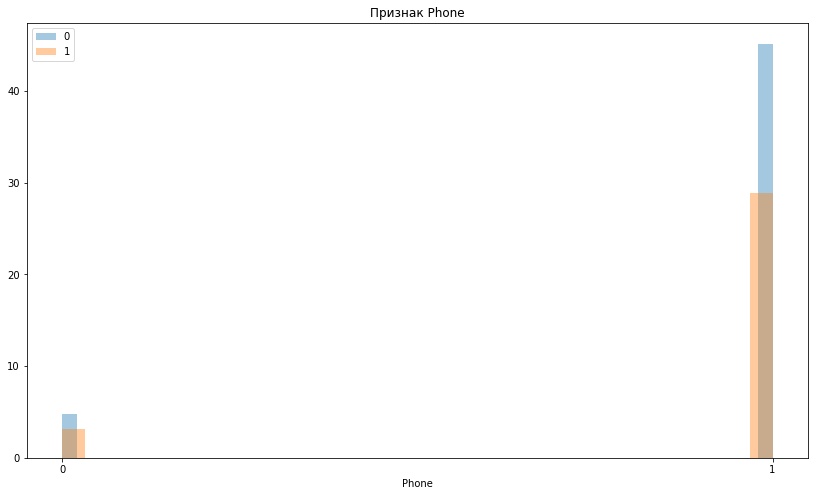

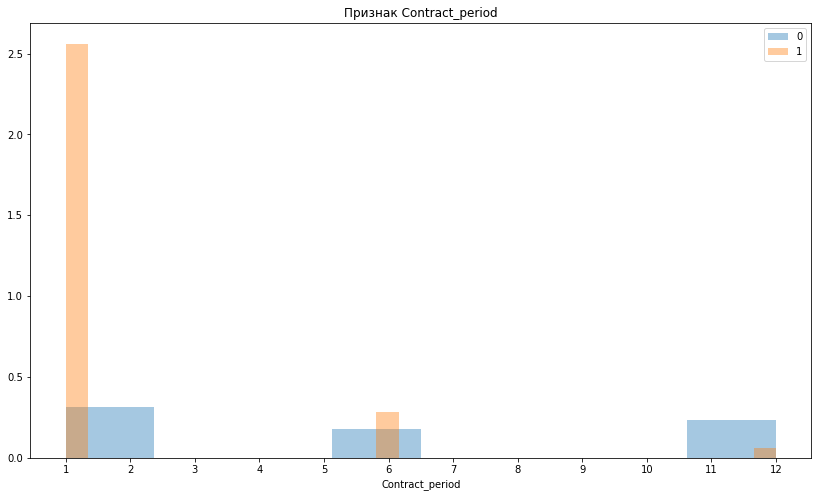

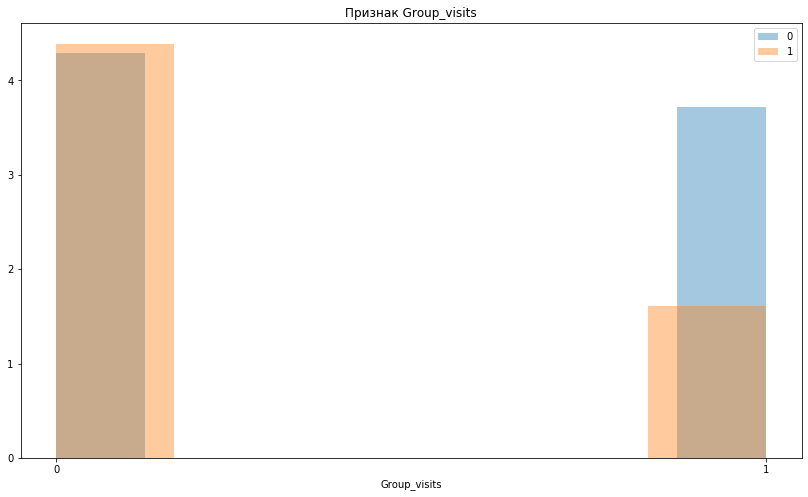

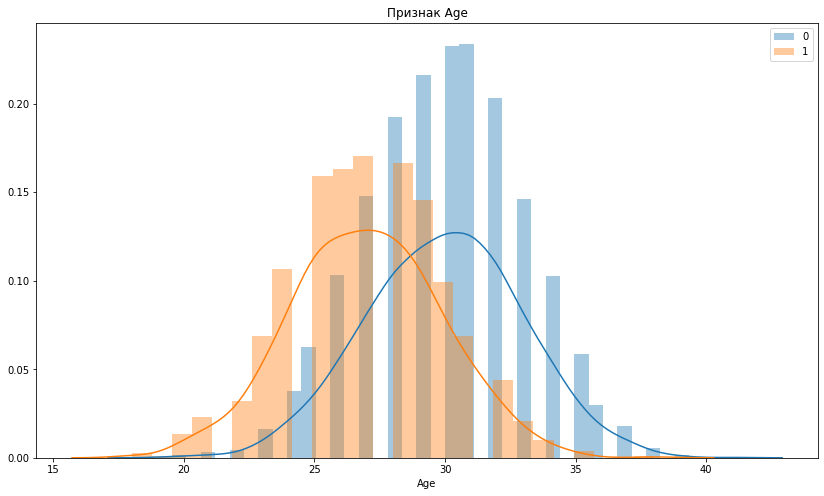

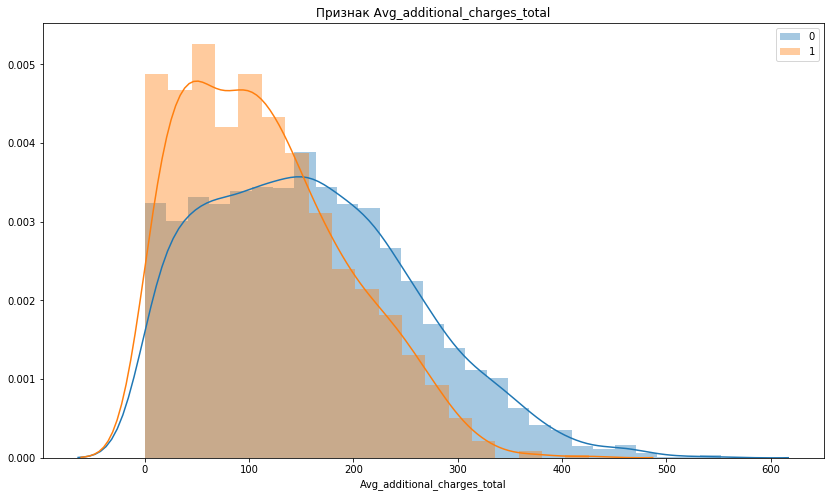

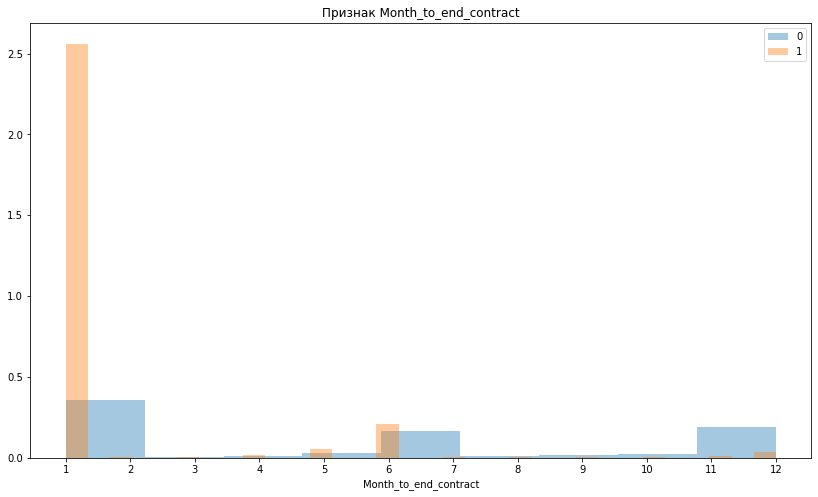

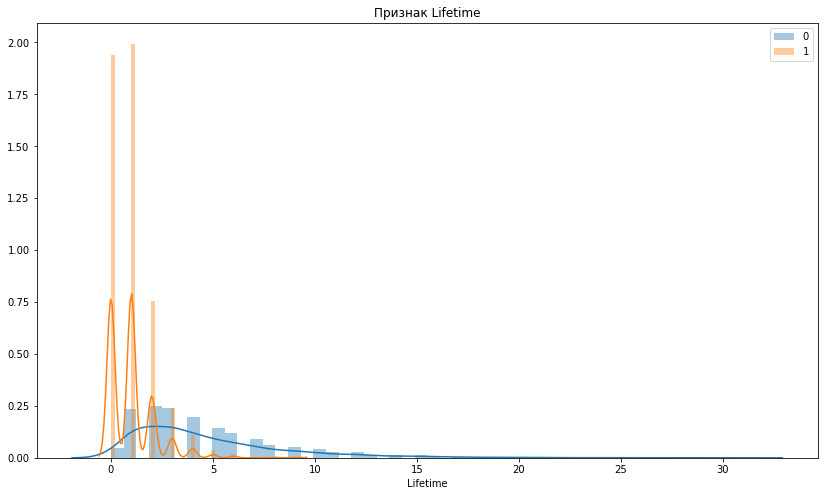

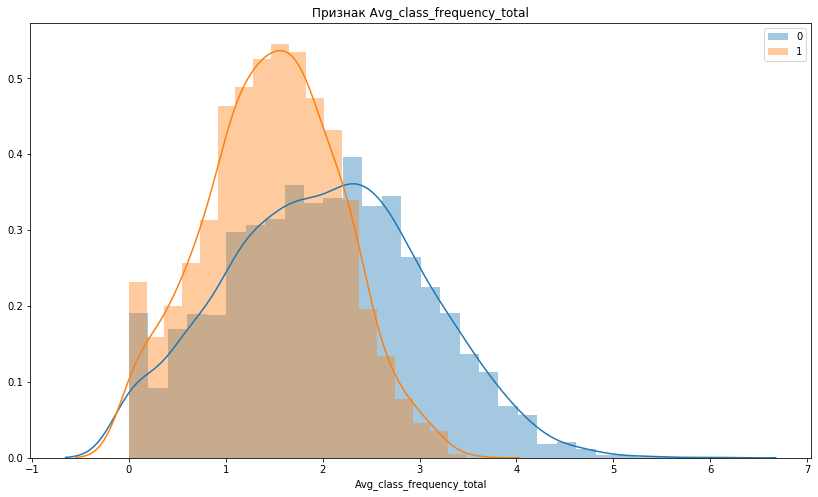

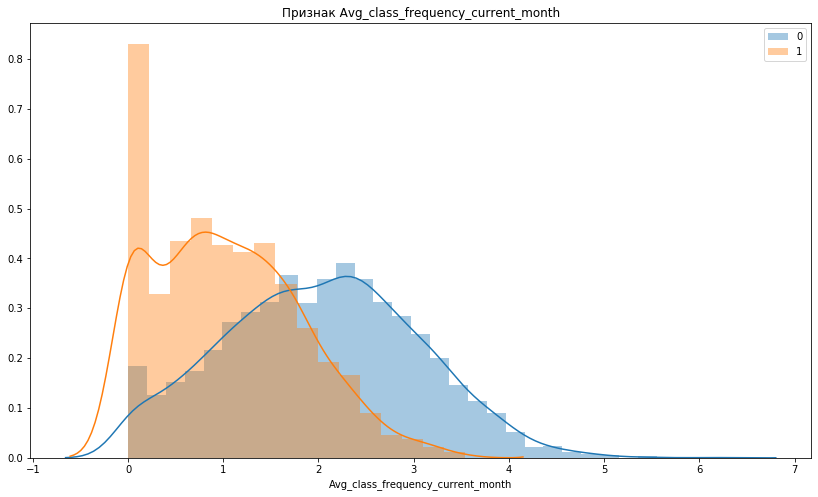

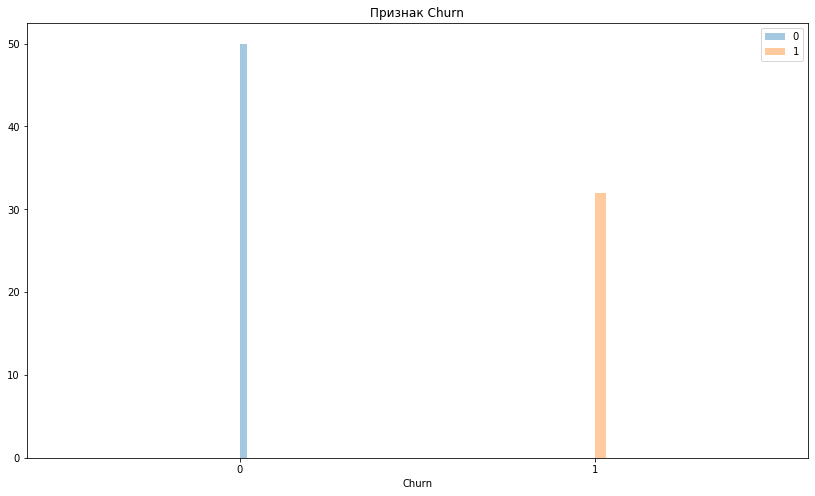

In [12]:
for i in df:
    if df[i].unique().shape[0] > 12:
        plt.figure(figsize=(14, 8))
        sns.distplot(df.query('Churn == 0')[i], label='0')
        sns.distplot(df.query('Churn == 1')[i], label='1')
        plt.legend()
        plt.title('Признак {}'.format(i))
        plt.show()
    else:
        min_value = min(df[i])
        max_value = max(df[i])
        bins_range = np.linspace(min_value, max_value, df[i].unique().shape[0])
        plt.figure(figsize=(14, 8))
        sns.distplot(df.query('Churn == 0')[i], kde=False, norm_hist=True, label='0')
        sns.distplot(df.query('Churn == 1')[i], kde=False, norm_hist=True, label='1')
        plt.legend()
        plt.xticks(np.arange(df[i].min(), df[i].max()+1))
        plt.title('Признак {}'.format(i))
        plt.show()        

In [13]:
df['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

<b>Выводы:</b>
* Распределение клиентов в оттоке смещено левее остальных
* Небинарные распределения имеют нормальное распределение

### Матрица корреляций

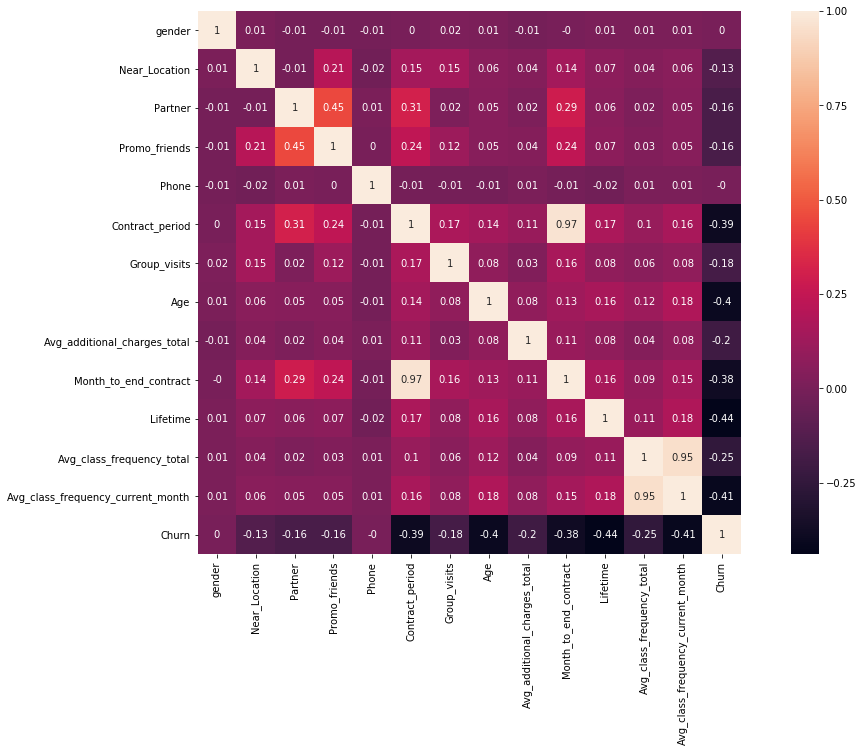

In [15]:
plt.figure(figsize=(18, 10))
sns.heatmap(df.corr().round(2), annot=True, square=True)
plt.show()

<b>Сильно коррелируют:</b>
* Avg_class_frequency_current_month и Avg_class_frequency_total - 0.95
* Contract_period и Month_to_end_contract - 0.95

Эти два столбца можно удалить из данных

## Построение модели прогнозирования оттока клиентов

### Разбивка данных на обучающую и валидационную выборку

In [16]:
df_train, df_test = train_test_split(df.drop(columns=['Avg_class_frequency_total', 
                                                      'Month_to_end_contract'], axis=1), test_size=0.20)

In [17]:
train_features = df_train.drop(columns='Churn', axis=1)
train_target = df_train['Churn']

In [18]:
test_features = df_test.drop(columns='Churn', axis=1)
test_target = df_test['Churn']

### Обучение модели на train-выборке двумя способами: логистической регрессией, случайным лесом

<b>Посмотрим на баланс классов</b>

In [19]:
df['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

26% клиентов - 1 класс(отток) и 73% - 0 класс. Следует уравновесить классы, чтобы не исказить значения метрик(применим простейший метод 'balanced', который контролирует веса). При таком дисбалансе опираться на метрику accuracy невозможно, следовательно надо опираться на precision и recall(для оценки возьму среднее гармоническое - f1 score)

In [20]:
#%%time
#np.random.seed(111)
#for i in ['accuracy', 'precision', 'recall', 'f1']:
#    reg = LogisticRegression(class_weight='balanced', solver='liblinear')
#    results = cross_val_score(reg, train_features, train_target, cv=5, scoring=i, n_jobs=-1)
#    print(i, ":", results.mean())

accuracy : 0.8884412918183393
    
precision : 0.7280000752926249
    
recall : 0.9243647754959973
    
f1 : 0.8143601908138394
    
CPU times: user 646 ms, sys: 3.85 ms, total: 650 ms
            
Wall time: 656 ms

In [21]:
#for i in ['accuracy', 'precision', 'recall', 'f1']:
#    forest_model = RandomForestClassifier(random_state=223, n_estimators=100, class_weight='balanced')
#    forest_results = cross_val_score(forest_model, train_features, train_target, cv=5, 
#    scoring=i, n_jobs=-1)
#    print(i, ":", forest_results.mean())

accuracy : 0.901259183524618

precision : 0.8423370896650685

recall : 0.7707135398538114

f1 : 0.8048617378648675

In [22]:
tuned_parameters = {'C': [0.1, 0.5, 1, 5, 10, 50, 100]}
fold = KFold(n_splits=5, shuffle=True)
rand_mod = LogisticRegression(random_state=668, class_weight='balanced', solver='liblinear')
rand_clf = GridSearchCV(rand_mod, tuned_parameters, cv=fold, scoring='f1', n_jobs=-1, verbose=1)
rand_clf.fit(train_features, train_target)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.5s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=668, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [23]:
#display(rand_clf.best_score_)
#display(rand_clf.best_params_)

0.8258792006287474

{'C': 100}

<b>С небольшим отрывом выиграла модель LogisticRegression(у меня параллельно курс по DS идёт и в таких случаях RandomForestClassifier очень часто побеждала)</b>

Accuracy: 0.902
Precision: 0.761
Recall: 0.919


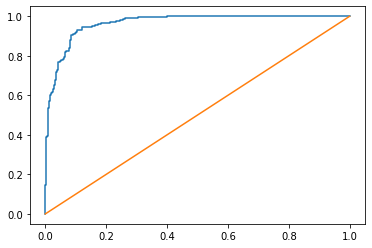

CPU times: user 296 ms, sys: 12 ms, total: 308 ms
Wall time: 321 ms


In [24]:
%%time
final_model = rand_clf.best_estimator_
final_model.fit(train_features, train_target)
predicted_random = final_model.predict(test_features)
random_proba = final_model.predict_proba(test_features)
random_one_test = random_proba[:, 1]
random_auc = roc_auc_score(test_target, random_one_test)
print("Accuracy: {:.3f}".format(accuracy_score(test_target, predicted_random)))
print("Precision: {:.3f}".format(precision_score(test_target, predicted_random)))
print("Recall: {:.3f}".format(recall_score(test_target, predicted_random)))
fpr, tpr, thresholds = roc_curve(test_target, random_one_test)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

### Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнение по ним модели.

In [62]:
feature_importances = pd.DataFrame(final_model.coef_.T, index=train_features.columns).reset_index()
feature_importances.columns = ['feature', 'value']
feature_importances = feature_importances.sort_values(by='value', ascending=True)

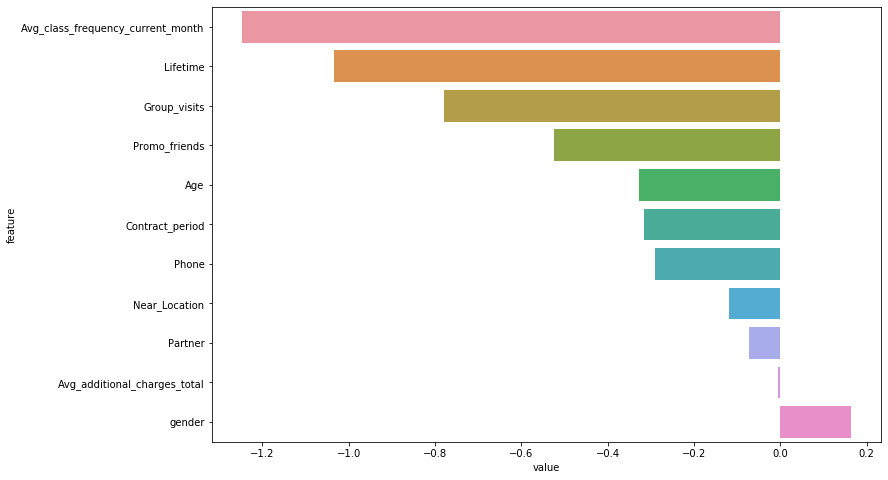

In [63]:
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances['value'], y=feature_importances['feature'])
plt.show()

<b>Выводы:</b>
* модель LogisticRegression выиграла с небольшим отрывом у модели RandomForestClassifier
* Топ 5 важных признака: Lifetime, Avg_class_frequency_current_month, Group_visits, Age, Promo_friends

## Кластеризация клиентов

### Нормализация данных

In [64]:
sc = StandardScaler()
x_sc = sc.fit_transform(df.drop(columns='Churn', axis=1))

### Матрица расстояний

In [65]:
linked = linkage(x_sc, method = 'ward')

In [66]:
#%%time
#plt.figure(figsize=(15, 10))  
#dendrogram(linked, orientation='top')
#plt.show() 

<b>Полученная дендрограмма показывает и рекомендует использовать 4 кластера</b>

### Модель кластеризации

In [67]:
km = KMeans(n_clusters=4, random_state=987)

In [68]:
labels = km.fit_predict(x_sc)

In [69]:
df['cluster_km'] = labels

### Средние значения признаков для кластеров

In [70]:
cluster_means = df.groupby('cluster_km').mean()

In [71]:
cluster_means

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.489145,0.755767,0.385346,0.192673,1.0,1.895522,0.291723,28.042062,129.409699,1.802578,2.232022,1.203721,0.949771,0.561737
1,0.541588,0.865784,0.335539,0.199433,1.0,2.386578,0.450851,30.005671,157.889886,2.224008,4.706994,2.714015,2.700512,0.092628
2,0.503697,0.940850,0.778189,0.573937,1.0,10.685767,0.533272,29.896488,161.102734,9.756932,4.720887,1.991351,1.983043,0.029575
3,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839


<b>Выводы по средним значениям:</b>
* Возраст во всех кластерах +/- 1
* По месту расположения: 3, 2, 0, 1
* По партнёрке 3, 0, 1, 2
* Промо акции 3, 0, 2, 1
* Контрактный период 3, 0, 2, 1
* 3-й кластер чаще посещают групповые занятия, затем 2, 0 и 1
* Суммарная выручка от других услуг - 3, 2, 0, 1
* Срок истечения контракта - 3, 0, 2, 1
* Время с момента первого обращения - 2, 3, 0, 1
* Средняя частота посещений за весь период - 2, 3, 0, 1
* Средняя частота за прошлый месяц - 2, 3, 0, 1

Сильнее всего выделается признак групповых визитов, контрактный период и промо акции у 1 кластера

У третьей группы самая высокая частота посещений в неделю за всё время


### Распределения признаков для кластеров

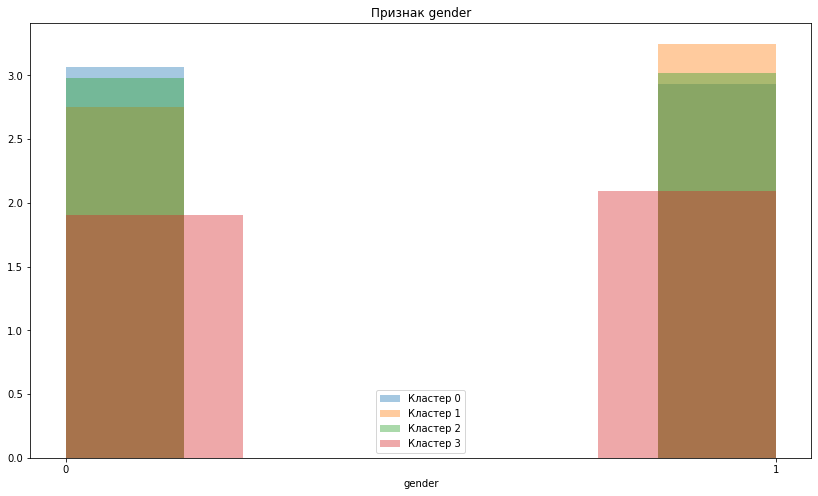

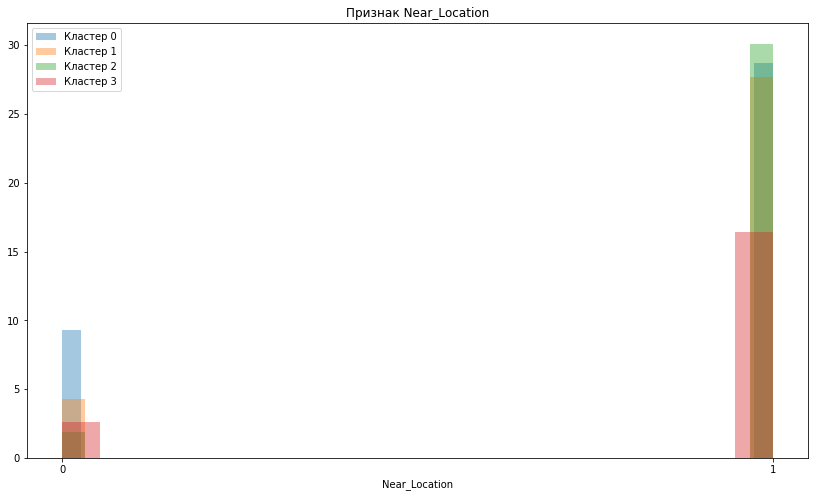

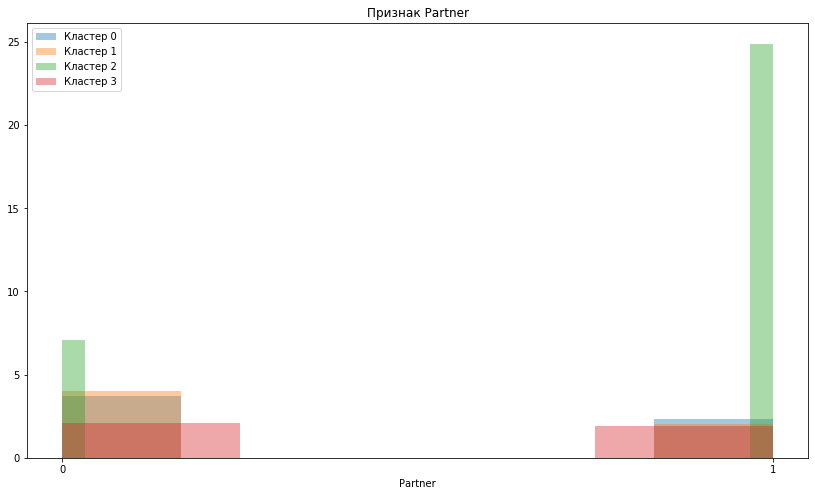

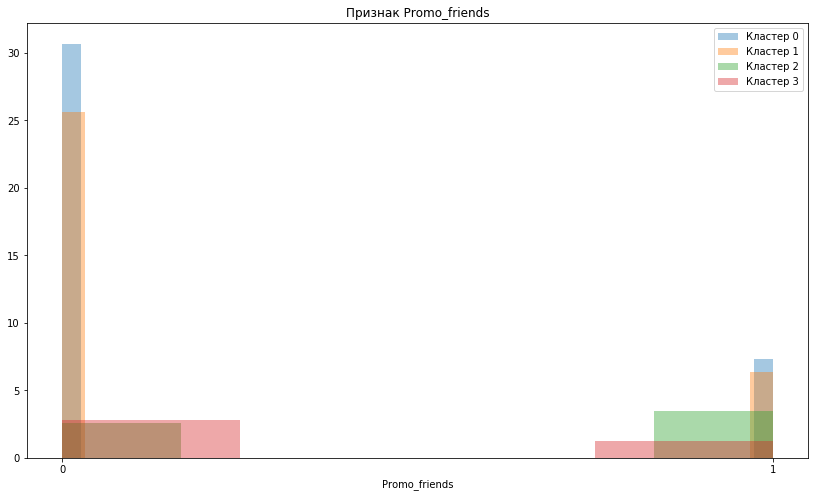

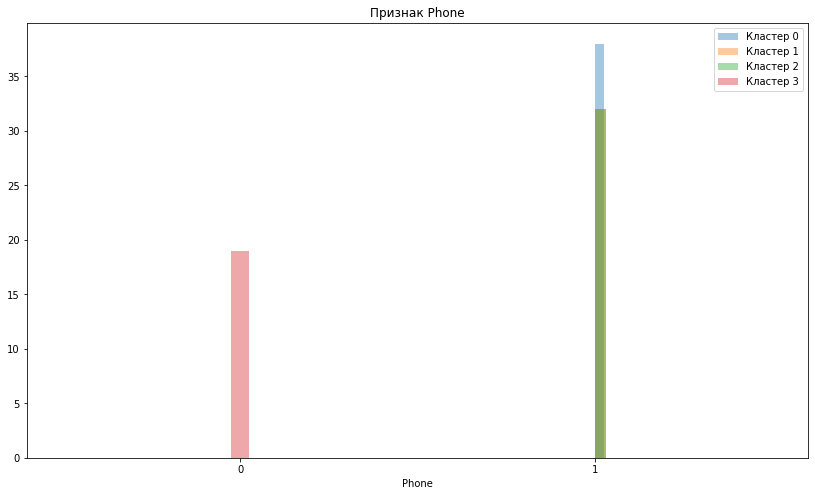

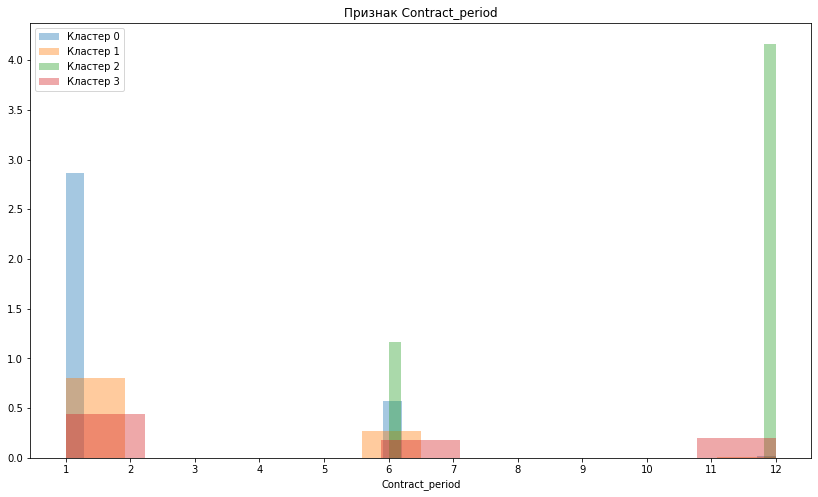

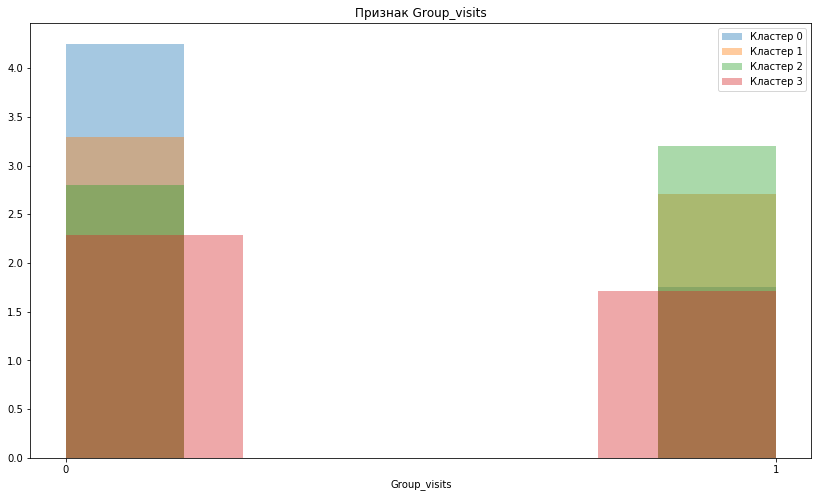

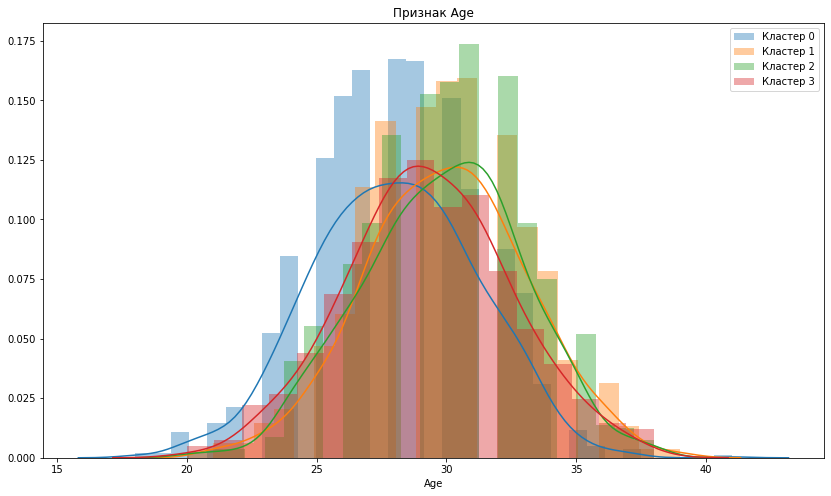

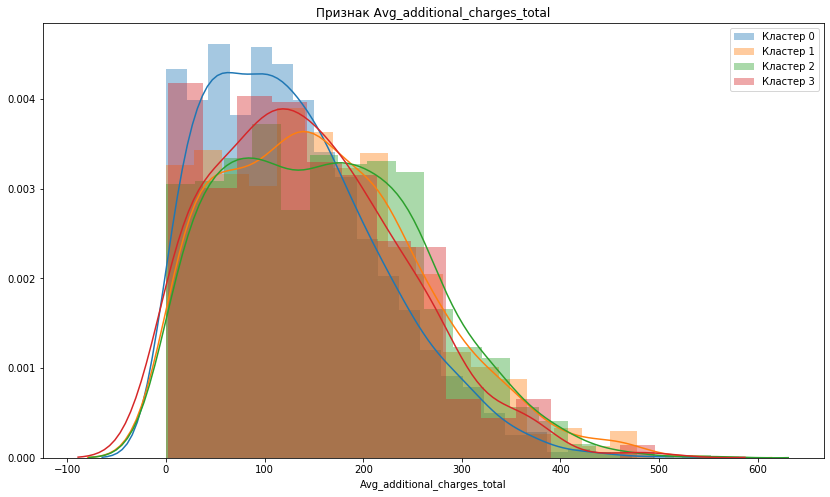

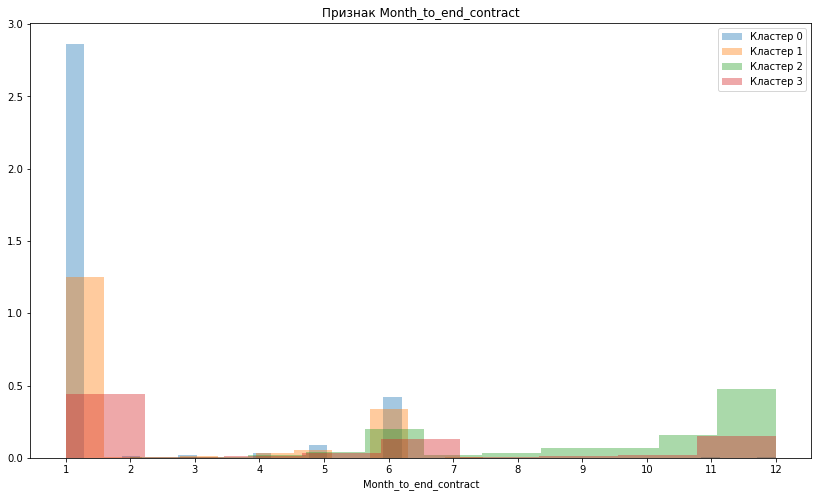

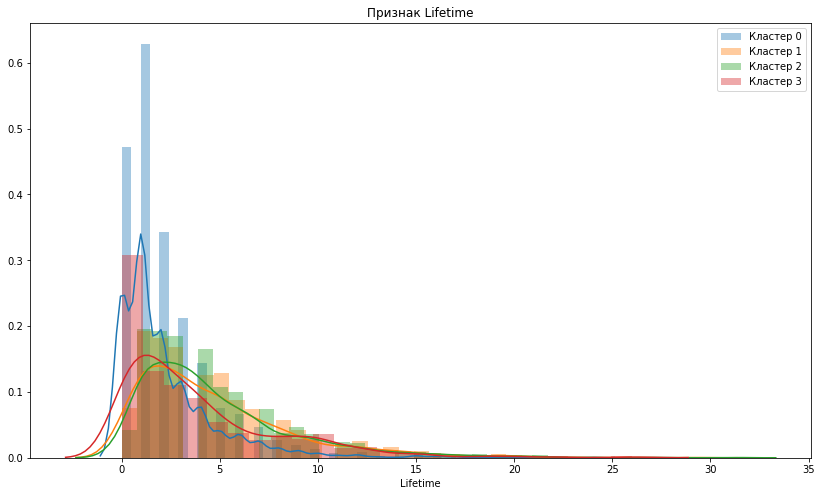

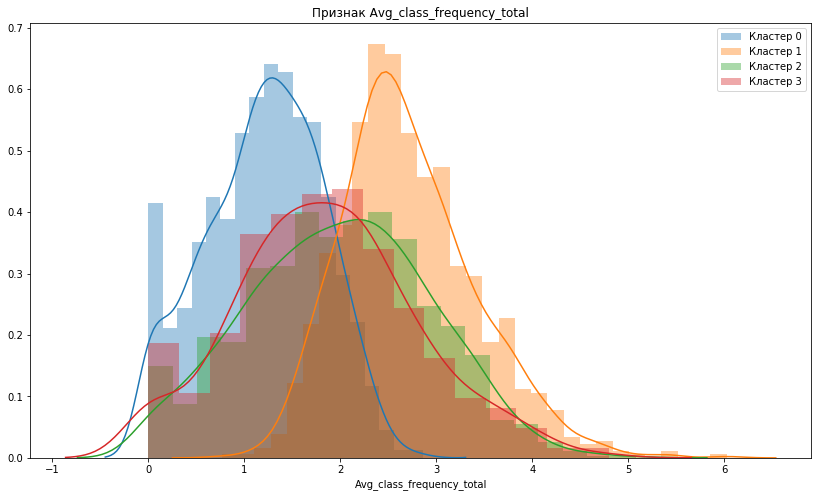

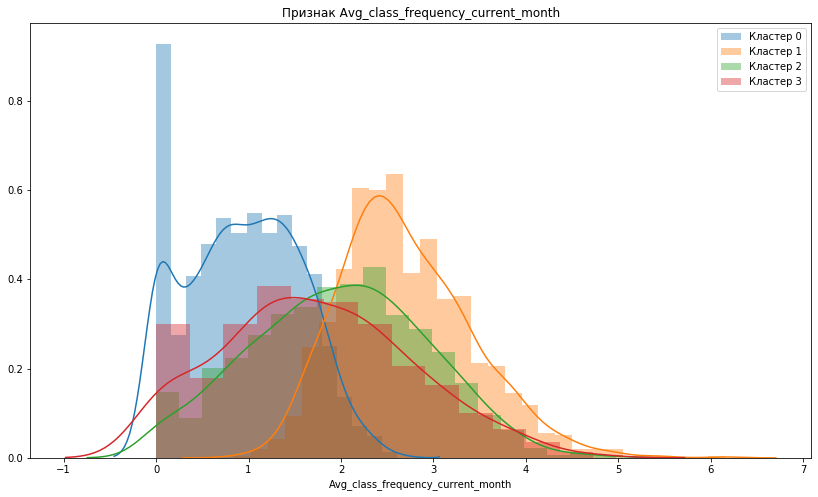

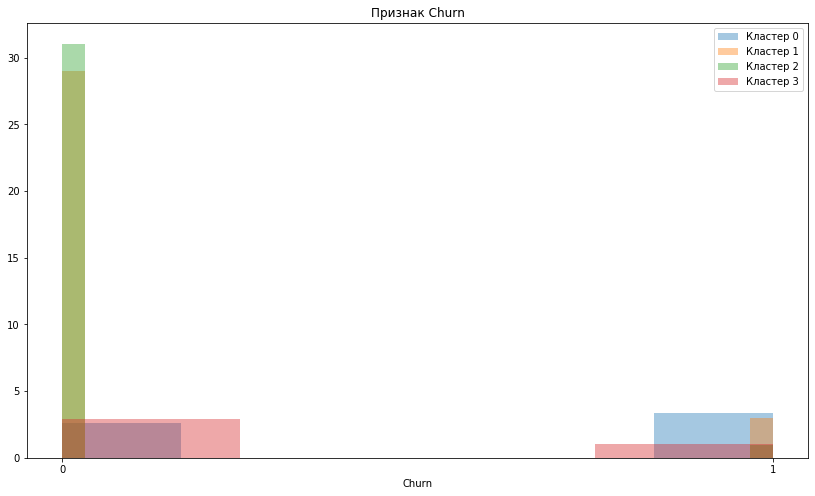

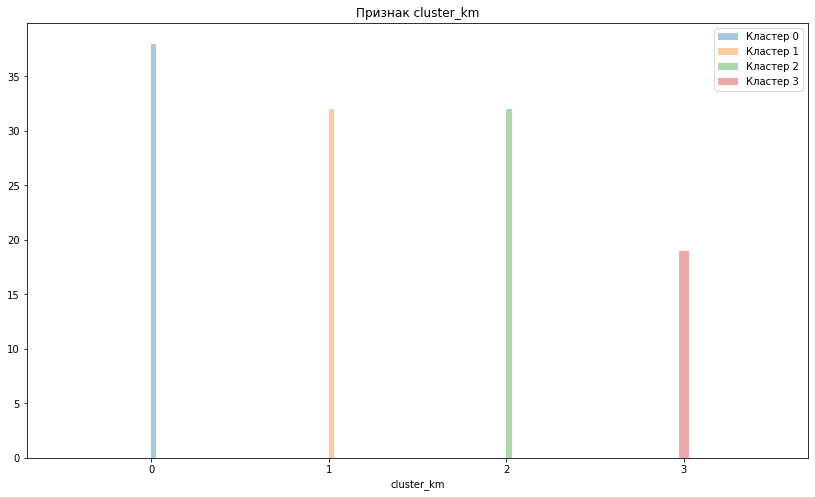

In [86]:
for i in df:
    if df[i].unique().shape[0] > 12:
        plt.figure(figsize=(14, 8))
        sns.distplot(df.query('cluster_km == 0')[i], label='Кластер 0')
        sns.distplot(df.query('cluster_km == 1')[i], label='Кластер 1')
        sns.distplot(df.query('cluster_km == 2')[i], label='Кластер 2')
        sns.distplot(df.query('cluster_km == 3')[i], label='Кластер 3')
        plt.legend()
        plt.title('Признак {}'.format(i))
        plt.show()
    else:
        plt.figure(figsize=(14, 8))
        sns.distplot(df.query('cluster_km == 0')[i], kde=False, norm_hist=True, label='Кластер 0')
        sns.distplot(df.query('cluster_km == 1')[i], kde=False, norm_hist=True, label='Кластер 1')
        sns.distplot(df.query('cluster_km == 2')[i], kde=False, norm_hist=True, label='Кластер 2')
        sns.distplot(df.query('cluster_km == 3')[i], kde=False, norm_hist=True, label='Кластер 3')        
        plt.legend()
        plt.xticks(np.arange(df[i].min(), df[i].max()+1))
        plt.title('Признак {}'.format(i))
        plt.show()        

In [83]:
df['Contract_period'].unique()

array([ 6, 12,  1])

<b>Взглянем на метрику силуэта(внутрикластерных и межкластерных расстояний)</b>

In [74]:
silhouette_score(x_sc, labels)

0.13397261596660962

<b>Вывод:</b>
Метрика силуэта показывает значение 0.13, что очень далеко от идеального значения 1

<b>Вывод по графикам распределения:</b>
* Клиентов попавших в отток по расположению к залу больше всего, что тех, кто приезжает издалека
* Среди клиентов являющихся сотрудниками компании-партнёра клиентов 2 кластера больше всего
* В 0 и 1 кластере больше всего клиентов, которые воспользовались промо-кодом
* Клиенты 3 кластера менее охотно дают свой номер телефона
* У 0 кластера - самый короткий контрактный период - 1 месяц, а у 2 кластера самый большой - 12 месяцев
* У 0 кластера самый низкий показатель посещения групповых занятий
* У 0 кластера самая низкая частота посещения зала в неделю, с момента приобретения абонемента, а также низкая средняя выручка с доп. услуг клуба (в срелнем ~100)
* У 0 кластера самое короткое время с момента первого обращения в клуб - в среднем 1 месяц

### Для каждого полученного кластера подсчёт доли оттока

In [79]:
for i in range(4):
    display("Cluster: {}, cluster size: {}".format(i, len(df.query('cluster_km == @i'))), 
            df.query('cluster_km == @i')['Churn'].value_counts() / len(df.query('cluster_km == @i')) * 100)

'Cluster: 0, cluster size: 1474'

1    56.173677
0    43.826323
Name: Churn, dtype: float64

'Cluster: 1, cluster size: 1058'

0    90.73724
1     9.26276
Name: Churn, dtype: float64

'Cluster: 2, cluster size: 1082'

0    97.042514
1     2.957486
Name: Churn, dtype: float64

'Cluster: 3, cluster size: 386'

0    73.316062
1    26.683938
Name: Churn, dtype: float64

In [89]:
cluster_means.T

cluster_km,0,1,2,3
gender,0.489145,0.541588,0.503697,0.523316
Near_Location,0.755767,0.865784,0.940850,0.862694
Partner,0.385346,0.335539,0.778189,0.471503
Promo_friends,0.192673,0.199433,0.573937,0.305699
Phone,1.000000,1.000000,1.000000,0.000000
Contract_period,1.895522,2.386578,10.685767,4.777202
Group_visits,0.291723,0.450851,0.533272,0.427461
Age,28.042062,30.005671,29.896488,29.297927
Avg_additional_charges_total,129.409699,157.889886,161.102734,144.208179
Month_to_end_contract,1.802578,2.224008,9.756932,4.466321


<b>Выводы:</b>
* Больше всего отточных клиентов попадают в нулевом кластере(56%) и третьем(26%)
* Первый и второй кластеры  - самые надёжные

Наиболее явные закономерности у <b>0 и 3 кластера</b>:
* Небольшое время с момента первого обращения в клуб(lifetime): У нулевойго кластера 1.8 месяца, у третьего 3.9 месяца. У 1 и 2 кластера - 4.5 месяца
* У 0 и 3 кластера снизилась частота посещения групповых занятий
* Суммарная выручка за доп. услуги клуба у 3 кластера упала до 144, а у нулевого до 129. Выручка 1 и 2 кластера: 157-161
* Частота посещения клуба за всё время действия абонемента упала с 2-2.5 (первый и второй кластер) до 1.2-1.8 дней в неделю у нулевого и третьего кластера
    * Частота посещений за предыдущий месяц(хотя current(англ.)-текущий, так что опечатка) частота у нулевого и третьего кластера: 0.9-1.7 раз в неделю. У 1 и 2: 1.9-2.7 раз в неделю
* Время действия контракта у 0 и 3 кластера - 1.8 и 4.7 месяцев. У 1 и 2 кластера - 2.3 и 10.6 месяцев
    * До завершения контракта у 0 и 3 кластера - 1.8 и 4.4 месяцев. У 1 и 2 кластера - 2.2 и 9.7 месяцев

<b>Вывод:</b> Клиенты, попавшие в третий кластер только начинают попадать в категорию оттока, а 0 кластер - там уже чаще встречаются те клиенты, что попадают в отток

## Выводы и базовые рекомендации по работе с клиентами

1. Целевые группы клиентов:

1 и 2 кластеры считаются самыми надёжными. У них высокая средняя частота посещаемости клуба в неделю, часто посещают групповые занятия и много платят за дополнительные услуги клуба.


2. Меры по снижению оттока:

Хоть промо-код и работает эффективно, но клиентов 0 и 3 кластера следует стимулировать чаще посещать зал
 * Ввиду частого отсуствия номера телефона в договоре у третьего кластера следует его уточнить - это всё таки источник информирования клиента о новых акциях и изменениях клуба
 * Клиенты 0 кластера ещё новенькие, поэтому менеджерам надо уделить им больше внимания. А 3-й кластер(у которых стала снижаться частота посещений) следует опросить, что им не нравится и из-за чего они стали реже ходить
 * Клиенты стали реже пользоваться дополнительными услугами клуба - узнать, не увеличивались ли цены на эти услуги
 * Для новых клиентов следует запускать разные марафоны по снижению веса, предоставлять скидки на персональных тренеров и тренеров групповых занятий, чтобы они вошли во вкус и продолжили заниматься дальше
 * Если клиенты пришли летом, то делать им скидки на разные услуги(часто этот период самый плохой по посещаемости, все едут на море)
 * Сделать посещение групповых занятий более удобным по времени для клиентов, которые стали их реже посещать


3. Другие особенности взаимодействия с клиентами

 * Проводить опросы о качестве предоставляемых услуг. Усилить наставничество тренеров клуба
 * Разработать скидочную систему на дополнительные услуги клуба. Добавить бесплатные консультации тренеров и медицинских специалистов
 * Каждый месяц добавлять несколько пробных визитов, занятий и медицинских тестов, spa услуг